# TransE model

This notebook is the implementation of TransE model that is presented in [this article](https://papers.nips.cc/paper/2013/file/1cecc7a77928ca8133fa24680a88d2f9-Paper.pdf).

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import Tensor
import torch.nn as nn
import torch.optim as optim

In [3]:
from tqdm import tqdm

In [4]:
from typing import List, Tuple

## Dataset processing

In [43]:
# Reading data from file
datapath = 'Dataset/train.txt'
triple_raw_data = pd.read_table(datapath, header=None, names=['h', 'l', 't'])
triple_raw_data.head(5)

,h,l,t
0,/m/027rn,/location/country/form_of_government,/m/06cx9
1,/m/017dcd,/tv/tv_program/regular_cast./tv/regular_tv_app...,/m/06v8s0
2,/m/07s9rl0,/media_common/netflix_genre/titles,/m/0170z3
3,/m/01sl1q,/award/award_winner/awards_won./award/award_ho...,/m/044mz_
4,/m/0cnk2q,/soccer/football_team/current_roster./sports/s...,/m/02nzb8


In [44]:
# Checking the size of data
len(triple_raw_data)

272115

In [45]:
class Encounter:
    '''
        This is custom class that translates the names of entities
        and relations to ids
    '''
    def __init__(self, raw_dataset: pd.DataFrame):
        '''
            Initialsing of entities and realtionships

            Parameters:
                raw_dataset (pd.DataFrame): dataframe of dataset that contains
                head (h), relationship (l) and tail (t)
        '''
        self.entities = set(raw_dataset['h'])
        self.entities.update(raw_dataset['t'])
        self.realtionships = set(raw_dataset['l'])

        self.entities = {elem: pos for pos, elem in enumerate(self.entities)}
        self.realtionships = {elem: pos for pos, elem in enumerate(self.realtionships)}
    
    def get(self, triple: List[str]) -> Tuple[int, int, int]:
        '''
            Get the ids of head (h), relationship (l) and tail (t)

            Parameters:
                triple (List[str]): list of head, relationship, tail names.
                Should have size 3

            Returns:
                h_id (int): id of head in encounter
                l_id (int): id of relationship in encounter
                t_id (int): id of tail in encounter
        '''
        assert len(triple) == 3, 'Triple should have size 3'
        h_id = self.entities[triple[0]]
        l_id = self.realtionships[triple[1]]
        t_id = self.entities[triple[2]]
        return h_id, l_id, t_id

    def entities_len(self) -> int:
        '''
            Return the number of entities (heads and tails) ids 

            Returns:
                len (int): the number of entities ids
        '''
        return len(self.entities)

    def relationships_len(self) -> int:
        '''
            Return the number of relationships ids 

            Returns:
                len (int): the number of relationships ids
        '''
        return len(self.realtionships)

In [46]:
class RelationDataset(Dataset):
    '''
        Implemaentation of torch.utils.data.Dataset
    '''
    def __init__(self, raw_dataset: pd.DataFrame):
        '''
            Initialsing of entities, realtionships and encounter
            that transform the names to ids

            Parameters:
                raw_dataset (pd.DataFrame): dataframe of dataset that contains
                head (h), relationship (l) and tail (t)
        '''
        self.dataset = raw_dataset
        self.encounter = Encounter(raw_dataset)

    def __len__(self) -> int:
        '''
            Return the size of dataset

            Returns:
                len (int): the size of dataset
        '''
        return len(self.dataset)

    def __getitem__(self, idx: int) -> Tuple[int, int, int]:
        '''
            Return the size of dataset

            Parameters:
                idx (int): the index of getting item

            Returns:
                data_item (Tuple[int, int, int]): the ids
                of head, relationship and tail
        '''
        data_item = list(self.dataset.loc[idx])
        return self.encounter.get(data_item)
    
    def entities_len(self) -> int:
        '''
            Return the number of entities (heads and tails) ids 

            Returns:
                len (int): the number of entities ids
        '''
        return self.encounter.entities_len()

    def relationships_len(self) -> int:
        '''
            Return the number of relationships ids 

            Returns:
                len (int): the number of relationships ids
        '''
        return self.encounter.relationships_len()

In [47]:
# Preparing dataset
train_dataset = RelationDataset(triple_raw_data)

In [48]:
# Preparing DataLoader
dataloader = DataLoader(train_dataset, batch_size=256,
                                     shuffle=True, num_workers=2)

## TransE model

In [49]:
class TransEImpl(nn.Module):
    '''
        This is the implemaentaion of TransE model
    '''
    def __init__(self, gamma: float, entities_len: int,
                 relationships_len: int, k: int, device: torch.device):
        '''
            Initialize the model:
                - creating embeddings for entities and relationships
                - normalizing the embeddings of relationships
                - initalize the loss function

            Parameters:
                gamma (float):           margin hyperparameter
                entities_len (int):      length of entities embedding
                relationships_len (int): length of relationships embedding
                k (int):                 space dimension for embeddings
                device (torch.device):   device to plug in
        '''
        super(TransEImpl, self).__init__()
        self.k = k
        self.device = device
        self.entities = self._create_embeddings(entities_len, k)
        self.relationships = self._create_embeddings(relationships_len, k)
        self.relationships.weight.data = nn.functional.normalize(
            self.relationships.weight.data, p=2.0, dim=0)
        
        # normalize the embeddings of relationships
        rn = torch.norm(self.relationships.weight, p=2, dim=1).detach()
        self.relationships.weight.div(rn.unsqueeze(1))

        # initalize the loss function
        self.criterion = nn.MarginRankingLoss(margin=gamma, reduction='sum')

    @staticmethod
    def _create_embeddings(num_emb: int, k: int) -> nn.Embedding:
        '''
            Static function that creates the embeddings

            Parameters:
                num_emb (int): number of embeddings
                k (int):       space dimension for embeddings

            Returns:
                embeddings (nn.Embedding): embedding module
        '''
        uniform_size = 6 / np.sqrt(k)
        embeddings = nn.Embedding(num_embeddings=num_emb,
                                     embedding_dim=k)
        embeddings.weight.data.uniform_(-uniform_size, uniform_size)
        return embeddings
        
    @staticmethod
    def _dissimilariy(triple: List[Tensor]) -> Tensor:
        '''
            Return the dissimilariy of head, realtionship and tale with
            formula:
                d(h + l, t) = ||h||^2_2 + ||l||^2_2 + ||t||^2_2 - 
                    2(h.T t + l.T (t - h))

            Parameters:
                triple (List[Tensor]): number of embeddings
                k (int):               space dimension for embeddings

            Returns:
                dissimilariy (Tensor): d(h + l, t)
        '''
        assert len(triple) == 3, 'List "triple" should have 3 tensors'
        h, l, t = triple
        return (torch.pow(torch.norm(h), 2) + 
                torch.pow(torch.norm(l), 2) + 
                torch.pow(torch.norm(t), 2) + 2 * 
                (torch.einsum('bi,bi->b', h, t) + 
                 torch.einsum('bi,bi->b', l, t - h)))
    
    def _id_to_emb(self, ids: Tensor) -> List[Tensor]:
        '''
            Return the embedding by the given number for heads, 
            relationships and tails

            Parameters:
                ids (Tensor): ids of heads, relationships and tails

            Returns:
                embs (List[Tensor]): List of heads, relationships and tails
                embeddings
        '''
        assert ids.shape[1] == 3, 'Tensor of ids should have shape bx3'
        h = self.entities.weight[ids[:,0]]
        l = self.relationships.weight[ids[:,1]]
        t = self.entities.weight[ids[:,2]]
        return [h, l, t]

    def normalize(self):
        '''
            Normalize the entities embeddings
        '''
        en = torch.norm(self.entities.weight, p=2, dim=1).detach()
        self.entities.weight.div(en.unsqueeze(1))

    def forward(self, good_triples_ids: Tensor, 
                corrupted_triples_ids: Tensor) -> Tensor:
        '''
            Return the loss function for pairs of good and corrupted triplets 

            Parameters:
                good_triples_ids (Tensor):      ids of good triples
                corrupted_triples_ids (Tensor): ids of corrupted triples

            Returns:
                loss (Tensor): loss function
        '''
        return self.loss(self._id_to_emb(good_triples_ids),
                         self._id_to_emb(corrupted_triples_ids))
    
    def predict_dist(self, triple_ids: Tensor) -> Tensor:
        '''
            Return the eucledian distance between h + l and t for given 
            triples of heads, relatioships and tails (h, l, t)

            Parameters:
                triple_ids (Tensor): ids of given heads, relatioships and tails

            Returns:
                dist (Tensor): distance for given triples
        '''
        h, l, t = self._id_to_emb(triple_ids)
        return torch.norm(h + l - t, p=2, dim=1)

    def loss(self, good_triples: List[Tensor], 
             corrupted_triples: List[Tensor]) -> Tensor:
        '''
            Return the loss function for given triples of heads, relatioships 
            and tails (h, l, t). Loss function for pair of good triple (h, l, t)
            and corrupted triple (h', l', t') counting by this formula:
            L = max(0, gamma + d(h + l,t) - d(h' + l,t'))

            Parameters:
                good_triples (List[Tensor]):      embeddings for 
                                                  good triples (h, l, t)
                corrupted_triples (List[Tensor]): embeddings for 
                                                  corrupted triples (h, l, t)

            Returns:
                loss (Tensor): loss function
        '''
        target = torch.tensor([-1], dtype=torch.long).to(self.device)
        return self.criterion(self._dissimilariy(good_triples),
                              self._dissimilariy(corrupted_triples), target)

In [50]:
class TransE:
    '''
        This is the class for training TransE model
    '''
    def __init__(self, dataset: RelationDataset, gamma: float = 0.01, 
                 k: int = 50, batch_size: int = 256, lr: float = 1e-4):
        '''
            Initialize the class:
                - create dataloader
                - create device
                - create and print TransE model
                - create optimizer

            Parameters:
                dataset (RelationDataset): given dataset
                gamma (float):             gamma for loss function
                k (int):                   space dimension for embeddings
                batch_size (int):          size of the batch
                lr (float):                learning rate
        '''
        self.dataloader = DataLoader(dataset, batch_size=batch_size,
                                     shuffle=True, num_workers=2)
        self.device = torch.device("cuda" 
                                   if torch.cuda.is_available() else "cpu")
        self.model = TransEImpl(gamma, 
                                dataset.entities_len(), 
                                dataset.relationships_len(),
                                k, self.device).to(self.device)
        print(self.model)
        self.optimizer = optim.SGD(self.model.parameters(), 
                                         lr=lr, weight_decay=1)
        self.k = k
        self.lr = lr

    def _train(self) -> Tuple[float, float]:
        '''
            One epoch of the model training

            Returns:
                mean_dist (float):  the mean dist between h + l and t
                                    after one epoch
                total_loss (float): total loss function after one epoch 
        '''
        self.model.train()

        total_loss = 0.
        mean_dists = []

        for i, batch in tqdm(enumerate(self.dataloader), desc='Train'):
            self.model.normalize()

            batch_triples = torch.hstack([ids.unsqueeze(1) for ids in batch])
            batch_triples = batch_triples.to(self.device)

            # Making corrupted triples
            corrupted_triples = batch_triples.clone().to(self.device)
            for j, _ in enumerate(batch_triples):
                idx_cor = np.random.randint(len(batch_triples))
                is_head = np.random.randint(2)
                head_or_tail = 0 if is_head else 2
                corrupted_triples[j][head_or_tail] = batch_triples[idx_cor][head_or_tail]

            self.optimizer.zero_grad()
            loss = self.model(batch_triples, corrupted_triples)
            loss.backward()

            self.optimizer.step()

            mean_dist = self.model.predict_dist(batch_triples).detach()
            mean_dists = mean_dists + mean_dist.tolist()

            total_loss += loss.item()
        
        return np.mean(mean_dists), total_loss

    def train_model(self, epochs: int = 10):
        '''
            Training process of the model

            Parameters:
                epochs (int): number of epochs
        '''
        self.dists = []
        self.losses = []
        for e in range(epochs):
            t_dist, t_loss = self._train()
            self.dists.append(t_dist)
            self.losses.append(t_loss)
            
            # Print epoch information
            print_str = f'| end of epoch {(e + 1):3d} ' \
                + f'| mean dist {t_dist:5.3f} ' \
                + f'| total loss {t_loss:5.3f} |'
            print()
            print('-' * len(print_str))
            print(print_str)
            print('-' * len(print_str))
            print()


In [51]:
def plot_training(k: int, lr: float, losses: List[float], dists: List[float]):
    '''
        Plotting two training graphics:
            - Epoch dependence loss function 
            - Epoch dependence distance 

        Parameters:
            k (int):              embedding dimension
            lr (float):           learning rate of the model
            losses (List[float]): total losses during all epochs
            dists (List[float]):  mean dists during all epochs
    '''
    x = [x for x in range(1, len(losses) + 1)]
    fig, (ax1, ax2) = plt.subplots(1, 2, layout='constrained', sharey='col')
    fig.set_figheight(8)
    fig.set_figwidth(20)

    # Plotting loss function dependence
    ax1.plot(x, losses)
    ax1.set_title('Loss', fontsize=20)
    ax1.set_xlabel('number of epochs, #', fontsize=16)
    ax1.set_ylabel('Loss', fontsize=16)

    # Plotting distance function dependence
    ax2.plot(x, dists)
    ax2.set_title('Distance between h+l and t', fontsize=20)
    ax2.set_xlabel('number of epochs, #', fontsize=16)
    ax2.set_ylabel('Distance', fontsize=16)

    fig.suptitle(f'TarnsE model k={k}, learning rate={lr}', fontsize=32)

    plt.show()

## Training the model

In [52]:
transE_25_1e_3 = TransE(train_dataset, k=25, lr=0.001)

TransEImpl(
  (entities): Embedding(14505, 25)
  (relationships): Embedding(237, 25)
  (criterion): MarginRankingLoss()
)


In [53]:
transE_25_1e_3.train_model()

Train: 1063it [00:28, 36.75it/s]


----------------------------------------------------------------
| end of epoch   1 | mean dist 2.570 | total loss 66366887.598 |
----------------------------------------------------------------




Train: 1063it [00:30, 34.87it/s]



---------------------------------------------------------------
| end of epoch   2 | mean dist 0.585 | total loss 9295923.235 |
---------------------------------------------------------------



Train: 1063it [00:29, 36.53it/s]



--------------------------------------------------------------
| end of epoch   3 | mean dist 0.164 | total loss 535558.485 |
--------------------------------------------------------------



Train: 1063it [00:29, 36.41it/s]


-------------------------------------------------------------
| end of epoch   4 | mean dist 0.053 | total loss 36513.899 |
-------------------------------------------------------------




Train: 1063it [00:30, 35.25it/s]


------------------------------------------------------------
| end of epoch   5 | mean dist 0.020 | total loss 4346.700 |
------------------------------------------------------------




Train: 1063it [00:29, 36.02it/s]


------------------------------------------------------------
| end of epoch   6 | mean dist 0.010 | total loss 2957.810 |
------------------------------------------------------------




Train: 1063it [00:29, 36.07it/s]


------------------------------------------------------------
| end of epoch   7 | mean dist 0.006 | total loss 2838.626 |
------------------------------------------------------------




Train: 1063it [00:29, 36.28it/s]


------------------------------------------------------------
| end of epoch   8 | mean dist 0.003 | total loss 2788.568 |
------------------------------------------------------------




Train: 1063it [00:28, 37.04it/s]


------------------------------------------------------------
| end of epoch   9 | mean dist 0.002 | total loss 2780.219 |
------------------------------------------------------------




Train: 1063it [00:28, 36.84it/s]



------------------------------------------------------------
| end of epoch  10 | mean dist 0.002 | total loss 2747.065 |
------------------------------------------------------------



In [54]:
transE_50_1e_3 = TransE(train_dataset, k=50, lr=0.001)

TransEImpl(
  (entities): Embedding(14505, 50)
  (relationships): Embedding(237, 50)
  (criterion): MarginRankingLoss()
)


In [55]:
transE_50_1e_3.train_model()

Train: 1063it [00:29, 35.89it/s]


----------------------------------------------------------------
| end of epoch   1 | mean dist 2.586 | total loss 66615411.274 |
----------------------------------------------------------------




Train: 1063it [00:28, 36.77it/s]


---------------------------------------------------------------
| end of epoch   2 | mean dist 0.586 | total loss 8711007.709 |
---------------------------------------------------------------




Train: 1063it [00:28, 36.70it/s]


--------------------------------------------------------------
| end of epoch   3 | mean dist 0.164 | total loss 586665.059 |
--------------------------------------------------------------




Train: 1063it [00:29, 35.61it/s]


-------------------------------------------------------------
| end of epoch   4 | mean dist 0.052 | total loss 33885.188 |
-------------------------------------------------------------




Train: 1063it [00:29, 36.50it/s]


------------------------------------------------------------
| end of epoch   5 | mean dist 0.019 | total loss 4710.721 |
------------------------------------------------------------




Train: 1063it [00:29, 36.33it/s]


------------------------------------------------------------
| end of epoch   6 | mean dist 0.009 | total loss 2830.017 |
------------------------------------------------------------




Train: 1063it [00:29, 35.51it/s]


------------------------------------------------------------
| end of epoch   7 | mean dist 0.005 | total loss 2794.419 |
------------------------------------------------------------




Train: 1063it [00:29, 36.29it/s]


------------------------------------------------------------
| end of epoch   8 | mean dist 0.003 | total loss 2761.758 |
------------------------------------------------------------




Train: 1063it [00:29, 36.26it/s]


------------------------------------------------------------
| end of epoch   9 | mean dist 0.002 | total loss 2731.412 |
------------------------------------------------------------




Train: 1063it [00:30, 35.38it/s]


------------------------------------------------------------
| end of epoch  10 | mean dist 0.001 | total loss 2758.277 |
------------------------------------------------------------



In [56]:
transE_25_1e_4 = TransE(train_dataset, k=25, lr=1e-4)

TransEImpl(
  (entities): Embedding(14505, 25)
  (relationships): Embedding(237, 25)
  (criterion): MarginRankingLoss()
)


In [57]:
transE_25_1e_4.train_model()

Train: 1063it [00:29, 36.23it/s]


---------------------------------------------------------------
| end of epoch   1 | mean dist 4.544 | total loss 9385219.402 |
---------------------------------------------------------------




Train: 1063it [00:29, 36.13it/s]


----------------------------------------------------------------
| end of epoch   2 | mean dist 4.033 | total loss 10091581.042 |
----------------------------------------------------------------




Train: 1063it [00:29, 35.59it/s]



---------------------------------------------------------------
| end of epoch   3 | mean dist 3.582 | total loss 9617614.019 |
---------------------------------------------------------------



Train: 1063it [00:29, 36.08it/s]


---------------------------------------------------------------
| end of epoch   4 | mean dist 3.172 | total loss 8393753.358 |
---------------------------------------------------------------




Train: 1063it [00:29, 35.95it/s]


---------------------------------------------------------------
| end of epoch   5 | mean dist 2.833 | total loss 6761120.814 |
---------------------------------------------------------------




Train: 1063it [00:28, 36.73it/s]


---------------------------------------------------------------
| end of epoch   6 | mean dist 2.514 | total loss 5690295.239 |
---------------------------------------------------------------




Train: 1063it [00:28, 37.16it/s]


---------------------------------------------------------------
| end of epoch   7 | mean dist 2.254 | total loss 4591505.244 |
---------------------------------------------------------------




Train: 1063it [00:28, 36.95it/s]


---------------------------------------------------------------
| end of epoch   8 | mean dist 1.993 | total loss 4001383.121 |
---------------------------------------------------------------




Train: 1063it [00:29, 36.10it/s]


---------------------------------------------------------------
| end of epoch   9 | mean dist 1.786 | total loss 3187532.544 |
---------------------------------------------------------------




Train: 1063it [00:28, 37.54it/s]


---------------------------------------------------------------
| end of epoch  10 | mean dist 1.612 | total loss 2307650.397 |
---------------------------------------------------------------



In [58]:
transE_50_1e_4 = TransE(train_dataset, k=50, lr=1e-4)

TransEImpl(
  (entities): Embedding(14505, 50)
  (relationships): Embedding(237, 50)
  (criterion): MarginRankingLoss()
)


In [ ]:
transE_50_1e_4.train_model()

Train: 1063it [00:28, 37.26it/s]



---------------------------------------------------------------
| end of epoch   1 | mean dist 4.579 | total loss 8385579.268 |
---------------------------------------------------------------



Train: 1063it [00:29, 36.21it/s]


----------------------------------------------------------------
| end of epoch   2 | mean dist 4.080 | total loss 10223934.682 |
----------------------------------------------------------------




Train: 1063it [00:28, 37.23it/s]



---------------------------------------------------------------
| end of epoch   3 | mean dist 3.617 | total loss 9486109.648 |
---------------------------------------------------------------



Train: 1063it [00:28, 37.32it/s]


---------------------------------------------------------------
| end of epoch   4 | mean dist 3.200 | total loss 8114705.790 |
---------------------------------------------------------------




Train: 1063it [00:28, 37.69it/s]


---------------------------------------------------------------
| end of epoch   5 | mean dist 2.868 | total loss 6722089.113 |
---------------------------------------------------------------




Train: 401it [00:10, 42.04it/s]

## Ploting the graphics

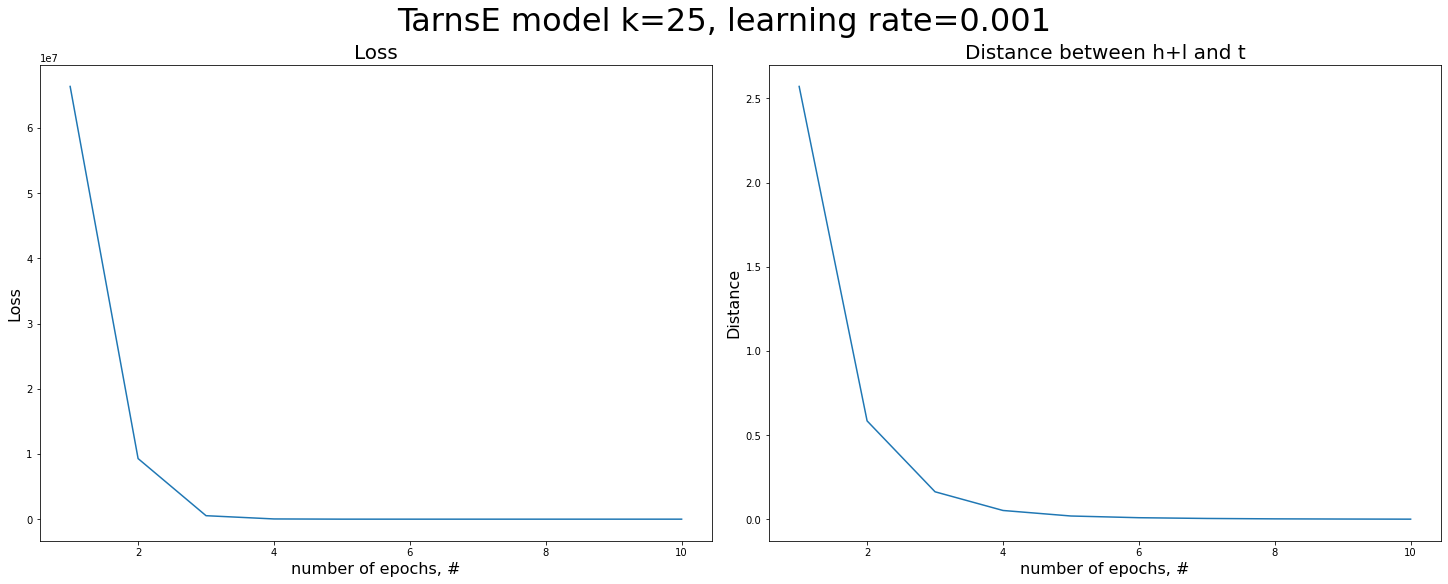

In [64]:
plot_training(transE_25_1e_3.k, transE_25_1e_3.lr, 
              transE_25_1e_3.losses, transE_25_1e_3.dists)

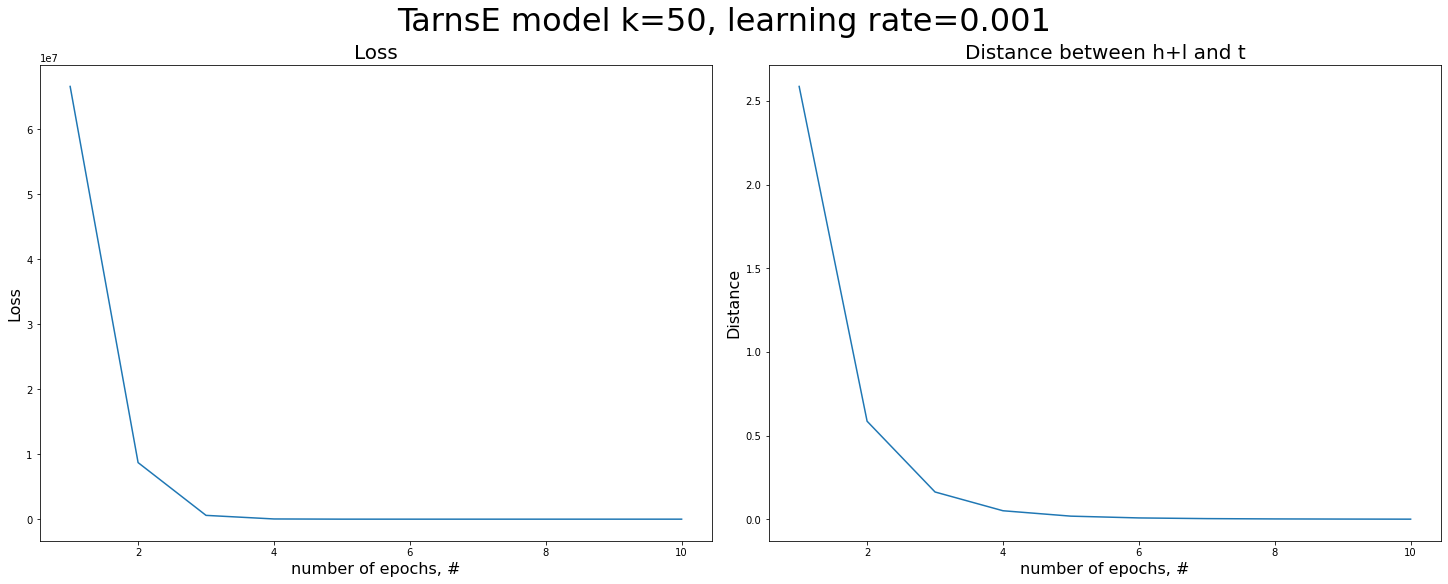

In [65]:
plot_training(transE_50_1e_3.k, transE_50_1e_3.lr, 
              transE_50_1e_3.losses, transE_50_1e_3.dists)

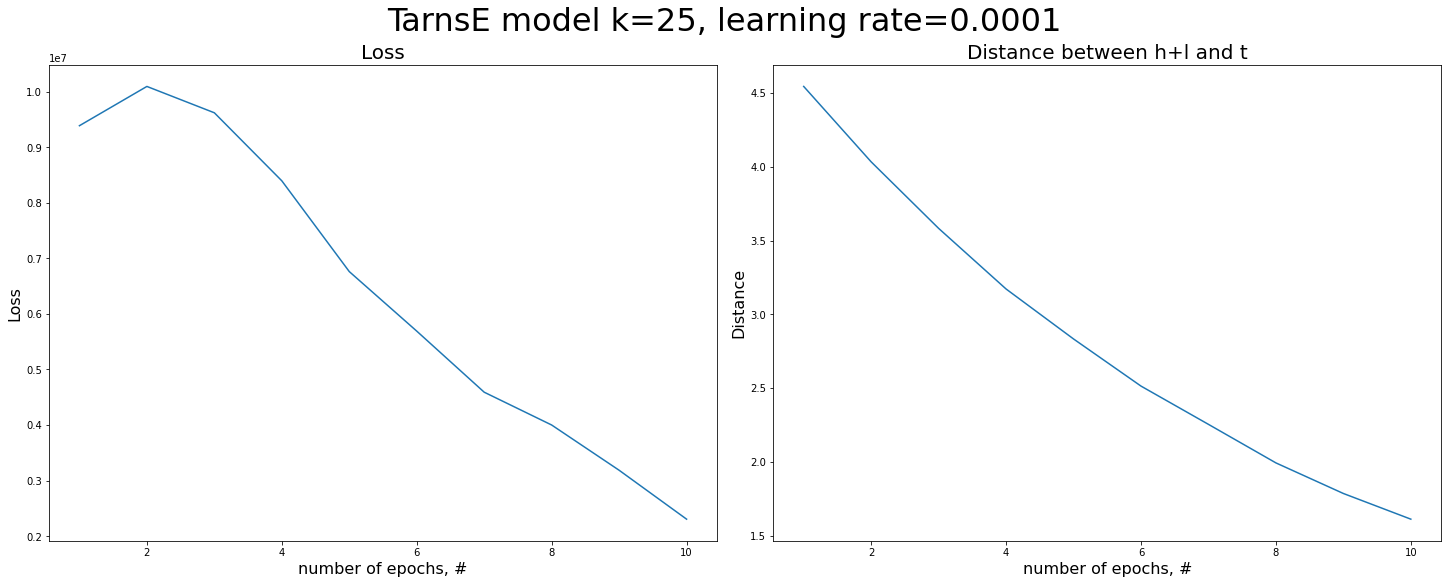

In [66]:
plot_training(transE_25_1e_4.k, transE_25_1e_4.lr, 
              transE_25_1e_4.losses, transE_25_1e_4.dists)

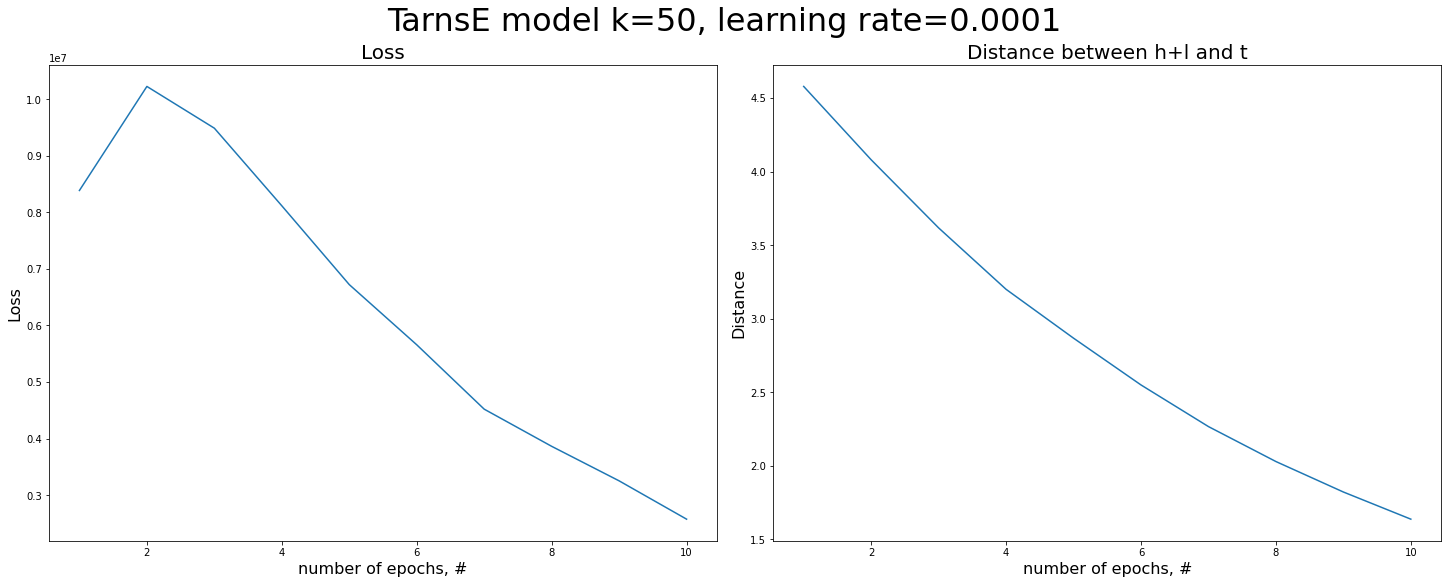

In [67]:
plot_training(transE_50_1e_4.k, transE_50_1e_4.lr, 
              transE_50_1e_4.losses, transE_50_1e_4.dists)